In [1]:
import numpy as np
import nest
import matplotlib.pyplot as plt
from matplotlib import rcParams 


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.3
 Built: May  5 2022 07:35:57

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.




Nov 24 11:02:47 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.01 ms.

Nov 24 11:02:47 NodeManager::prepare_nodes [Info]: 
    Preparing 70 nodes for simulation.

Nov 24 11:02:47 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 70
    Simulation time (ms): 1000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Nov 24 11:02:47 SimulationManager::run [Info]: 
    Simulation finished.


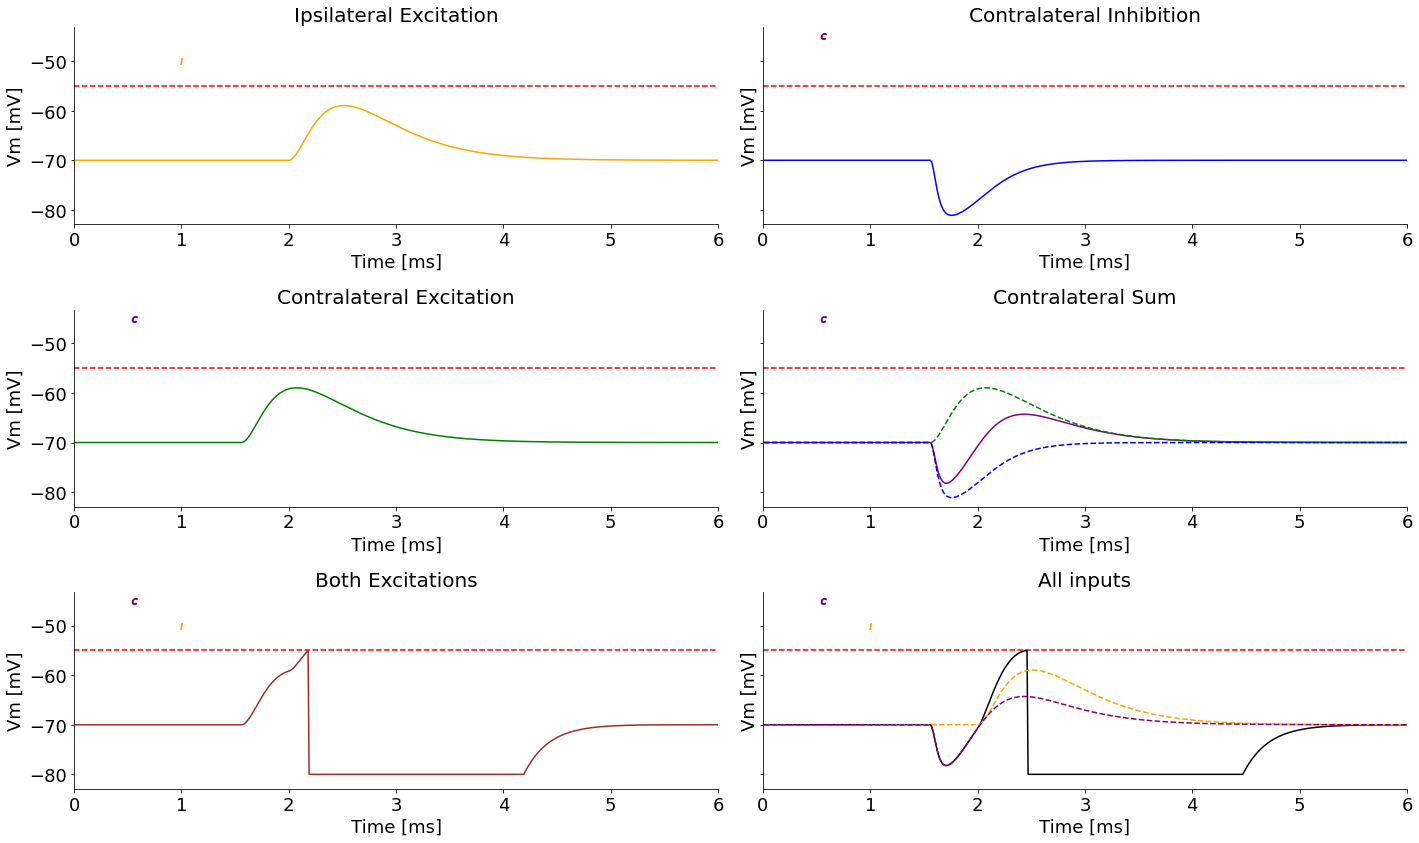

In [64]:
angle = -41

tone = 100
time_sim = 1000

C_mso = 4
delays_mso = [1,2,1,1] #ms
weights_mso = [3.9,-2,3.9,-64]
t_r_exc = 0.2
t_r_in = 0.1
t_d_exc = 0.4
t_d_in = 0.1


mean_rate = 0
mean_amplitude = 1000

w_head = 22 #cm
v_sound = 33000 #cm/s
delta_x = (w_head*np.sin(np.deg2rad(angle)))
itd = round(1000*delta_x/v_sound,2) #ms
ipd = 2*np.pi*itd*tone/1000

nest.ResetKernel()
nest.local_num_threads = 16
nest.resolution = 0.01 

"""ipsi_e = nest.Create('sinusoidal_poisson_generator', 1, 
                      params={'frequency': tone, 'rate': mean_rate, 'amplitude': mean_amplitude}) #ITDs

contra_e = nest.Create('sinusoidal_poisson_generator', 1,
                      params={'frequency': tone, 'rate': mean_rate, 'amplitude': mean_amplitude})
                      
"""

ipsi_e = nest.Create("spike_generator", 1, params={"spike_times": np.linspace(1.0,991.0,100)})

contra_e = nest.Create('spike_generator', 1, params={"spike_times": np.linspace(1.0+itd,991.0+itd,100)})



mso = nest.Create('iaf_cond_beta', 6,
                  params = {'V_reset': -80})

s = nest.Create('spike_recorder')
        
m = nest.Create('multimeter', 1, {"record_from": ['V_m']})
nest.SetStatus(m, {'interval': 0.01})

nest.Connect(mso, s, 'all_to_all')
nest.Connect(ipsi_e, s, 'one_to_one')
nest.Connect(contra_e, s, 'one_to_one')

nest.Connect(m, mso, 'all_to_all')

nest.Connect(ipsi_e, mso[0], 'one_to_one', syn_spec = {"weight":weights_mso[0], "delay": delays_mso[0]})
nest.Connect(ipsi_e, mso[2], 'one_to_one', syn_spec = {"weight":weights_mso[0], "delay": delays_mso[0]})

nest.Connect(contra_e, mso[1], 'one_to_one', syn_spec = {"weight":weights_mso[2], "delay": delays_mso[2]})
nest.Connect(contra_e, mso[2], 'one_to_one', syn_spec = {"weight":weights_mso[2], "delay": delays_mso[2]})

nest.Connect(contra_e, mso[3], 'one_to_one', syn_spec = {"weight":weights_mso[3], "delay": delays_mso[3]})
nest.Connect(contra_e, mso[4], 'one_to_one', syn_spec = {"weight":weights_mso[3], "delay": delays_mso[3]})
nest.Connect(contra_e, mso[4], 'one_to_one',  syn_spec = {"weight":weights_mso[2], "delay": delays_mso[2]})

nest.Connect(ipsi_e, mso[5], 'one_to_one',  syn_spec = {"weight":weights_mso[0], "delay": delays_mso[0]})
nest.Connect(contra_e, mso[5], 'one_to_one', syn_spec = {"weight":weights_mso[2], "delay": delays_mso[2]})
nest.Connect(contra_e, mso[5], 'one_to_one',  syn_spec = {"weight":weights_mso[3], "delay": delays_mso[3]})

for i in range(6):
    mso[i].set(C_m = C_mso, tau_rise_ex = t_r_exc, tau_rise_in = t_r_in, tau_decay_ex = t_d_exc, tau_decay_in = t_d_in)
    
nest.Simulate(time_sim)
data = s.get('events')
pot = m.get('events')

text_color = 'black' 
rcParams['text.color'] = text_color 
rcParams['axes.labelcolor'] = text_color 
rcParams['xtick.color'] = text_color 
rcParams['ytick.color'] = text_color 
plt.rc('font', size=16)          # controls default text sizes 
plt.rc('axes', titlesize=20)     # fontsize of the axes title 
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels 
plt.rc('xtick', labelsize=18)    # fontsize of the tick labels 
plt.rc('ytick', labelsize=18)    # fontsize of the tick labels 
plt.rc('legend', fontsize=16)    # legend fontsize 
plt.rc('figure', titlesize=26)  # fontsize of the figure title
col = ['orange', 'g', 'brown', 'blue', 'purple', 'k']
fig, ax = plt.subplots(3,2, figsize=(20,12), sharey = True)


for j in range(2):
    for i in range(3):
        ax[i, j].set_xlim(0,6)
        ax[i, j].axhline(y = mso[3*j+i].get('V_th'), color = 'r', linestyle = '--')
        ax[i, j].plot(pot['times'][np.where(pot['senders'] == mso[3*j+i].get('global_id'))], pot['V_m'][np.where(pot['senders'] == mso[3*j+i].get('global_id'))], color = col[3*j+i])
        ax[i, j].spines['top'].set_visible(False)
        ax[i, j].spines['right'].set_visible(False)
        ax[i, j].set_xlabel("Time [ms]")
        ax[i, j].set_ylabel("Vm [mV]")

ax[1, 1].plot(pot['times'][np.where(pot['senders'] == mso[1].get('global_id'))], pot['V_m'][np.where(pot['senders'] == mso[1].get('global_id'))], '--', color = col[1])
ax[1, 1].plot(pot['times'][np.where(pot['senders'] == mso[3].get('global_id'))], pot['V_m'][np.where(pot['senders'] == mso[3].get('global_id'))], '--', color = col[3])

ax[2, 1].plot(pot['times'][np.where(pot['senders'] == mso[0].get('global_id'))], pot['V_m'][np.where(pot['senders'] == mso[0].get('global_id'))], '--', color = col[0])
ax[2, 1].plot(pot['times'][np.where(pot['senders'] == mso[4].get('global_id'))], pot['V_m'][np.where(pot['senders'] == mso[4].get('global_id'))], '--', color = col[4])

ax[0, 0].set_title('Ipsilateral Excitation')
ax[1, 0].set_title('Contralateral Excitation')
ax[2, 0].set_title('Both Excitations')
ax[0, 1].set_title('Contralateral Inhibition')
ax[1, 1].set_title('Contralateral Sum')
ax[2, 1].set_title('All inputs')

ax[0,0].plot(data['times'][np.where(data['senders'] == ipsi_e.get('global_id'))], (-50)*np.ones(len(data['times'][np.where(data['senders'] == ipsi_e.get('global_id'))])), marker = '$i$', linestyle = 'None', color = col[0])
ax[2,0].plot(data['times'][np.where(data['senders'] == ipsi_e.get('global_id'))], (-50)*np.ones(len(data['times'][np.where(data['senders'] == ipsi_e.get('global_id'))])), marker = '$i$', linestyle = 'None', color = col[0])
ax[2,1].plot(data['times'][np.where(data['senders'] == ipsi_e.get('global_id'))], (-50)*np.ones(len(data['times'][np.where(data['senders'] == ipsi_e.get('global_id'))])), marker = '$i$', linestyle = 'None', color = col[0])
ax[1,0].plot(data['times'][np.where(data['senders'] == contra_e.get('global_id'))], (-45)*np.ones(len(data['times'][np.where(data['senders'] == contra_e.get('global_id'))])), marker = '$c$', linestyle = 'None', color = col[4])
ax[2,0].plot(data['times'][np.where(data['senders'] == contra_e.get('global_id'))], (-45)*np.ones(len(data['times'][np.where(data['senders'] == contra_e.get('global_id'))])), marker = '$c$', linestyle = 'None', color = col[4])
ax[0,1].plot(data['times'][np.where(data['senders'] == contra_e.get('global_id'))], (-45)*np.ones(len(data['times'][np.where(data['senders'] == contra_e.get('global_id'))])), marker = '$c$', linestyle = 'None', color = col[4])
ax[1,1].plot(data['times'][np.where(data['senders'] == contra_e.get('global_id'))], (-45)*np.ones(len(data['times'][np.where(data['senders'] == contra_e.get('global_id'))])), marker = '$c$', linestyle = 'None', color = col[4])
ax[2,1].plot(data['times'][np.where(data['senders'] == contra_e.get('global_id'))], (-45)*np.ones(len(data['times'][np.where(data['senders'] == contra_e.get('global_id'))])), marker = '$c$', linestyle = 'None', color = col[4])


fig.tight_layout()
#plt.savefig('angle{}.png'.format(angle))

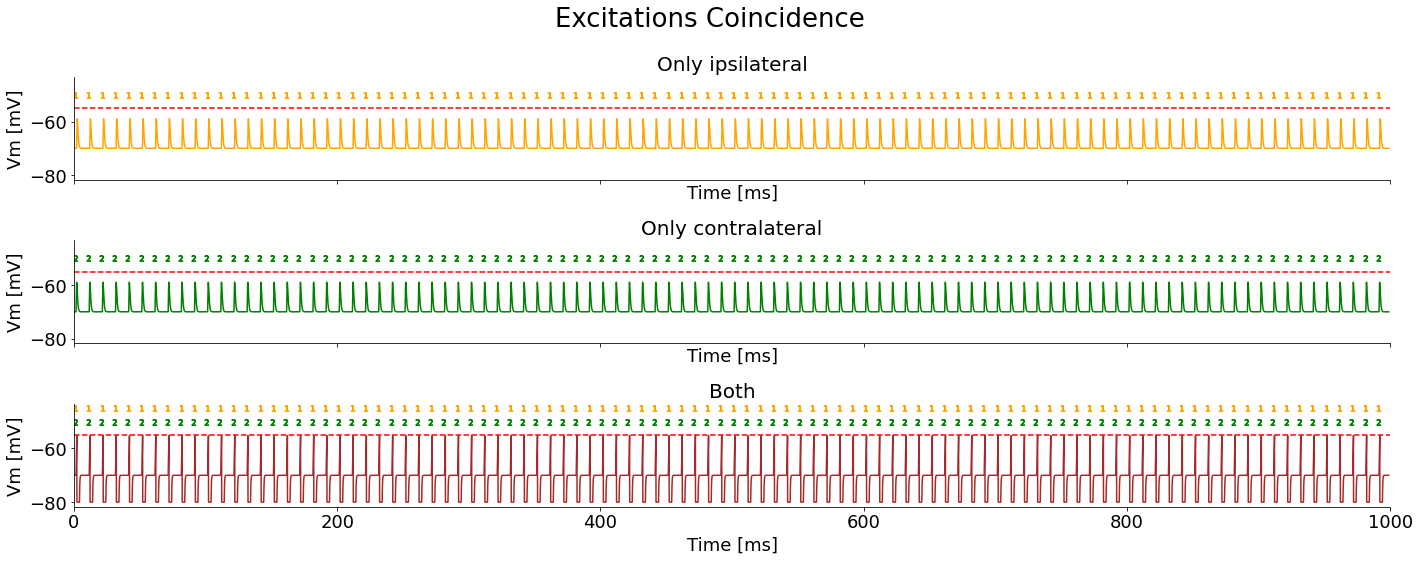

In [55]:
fig, ax = plt.subplots(3, figsize=(20,8), sharey = True, sharex = True)

for j in range(3):
    ax[j].set_xlim(0,1000)
    ax[j].axhline(y = mso[j].get('V_th'), color = 'r', linestyle = '--')
    ax[j].plot(pot['times'][np.where(pot['senders'] == mso[j].get('global_id'))], pot['V_m'][np.where(pot['senders'] == mso[j].get('global_id'))], color = col[j])
    ax[j].spines['top'].set_visible(False)
    ax[j].spines['right'].set_visible(False)
    ax[j].set_xlabel("Time [ms]")
    ax[j].set_ylabel("Vm [mV]")
    
fig.suptitle("Excitations Coincidence")

ax[0].set_title('Only ipsilateral')
ax[1].set_title('Only contralateral')
ax[2].set_title('Both')
ax[0].plot(data['times'][np.where(data['senders'] == ipsi_e.get('global_id'))], (-50)*np.ones(len(data['times'][np.where(data['senders'] == ipsi_e.get('global_id'))])), marker = '${}$'.format(ipsi_e.get('global_id')), linestyle = 'None', color = col[0])
ax[1].plot(data['times'][np.where(data['senders'] == contra_e.get('global_id'))], (-50)*np.ones(len(data['times'][np.where(data['senders'] == contra_e.get('global_id'))])), marker = '${}$'.format(contra_e.get('global_id')), linestyle = 'None', color = col[1])
ax[2].plot(data['times'][np.where(data['senders'] == ipsi_e.get('global_id'))], (-45)*np.ones(len(data['times'][np.where(data['senders'] == ipsi_e.get('global_id'))])), marker = '${}$'.format(ipsi_e.get('global_id')), linestyle = 'None', color = col[0])
ax[2].plot(data['times'][np.where(data['senders'] == contra_e.get('global_id'))], (-50)*np.ones(len(data['times'][np.where(data['senders'] == contra_e.get('global_id'))])), marker = '${}$'.format(contra_e.get('global_id')), linestyle = 'None', color = col[1])
fig.tight_layout()

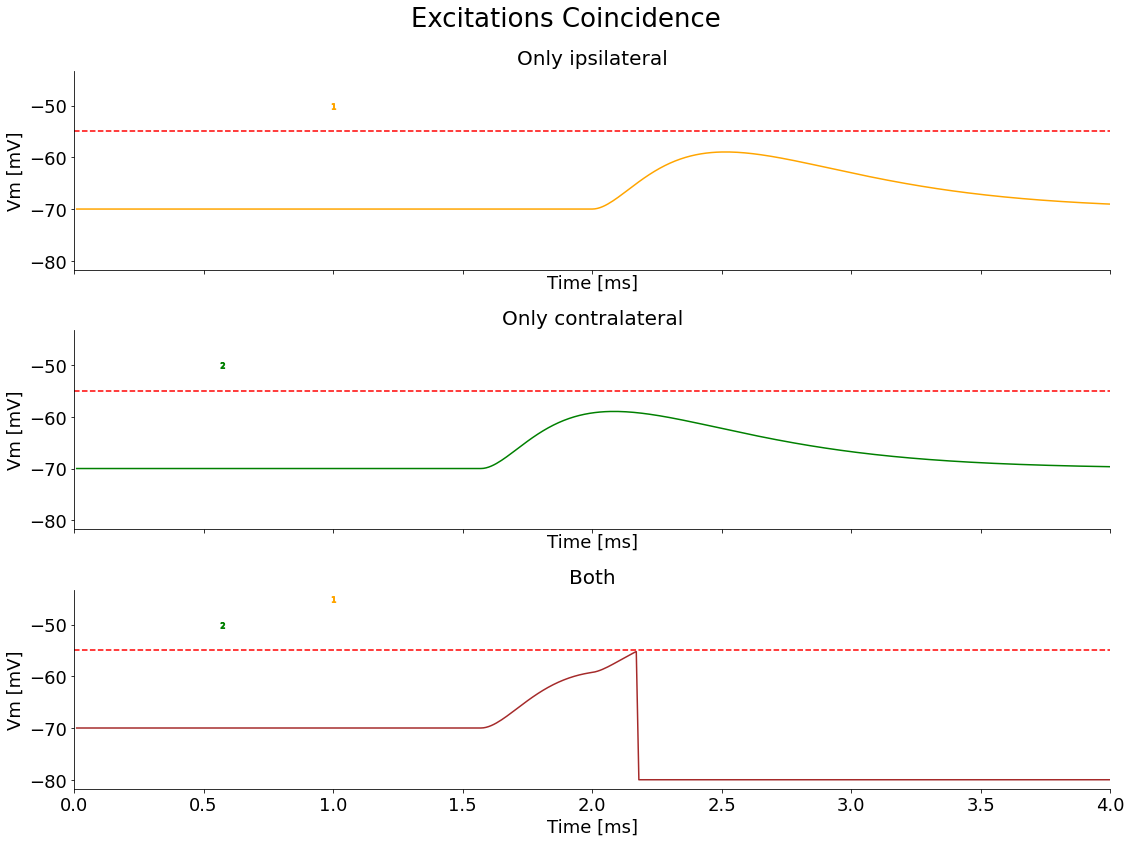

In [54]:
fig, ax = plt.subplots(3, figsize=(16,12), sharey = True, sharex = True)


for j in range(3):
    ax[j].set_xlim(0,4)
    ax[j].axhline(y = mso[j].get('V_th'), color = 'r', linestyle = '--')
    ax[j].plot(pot['times'][np.where(pot['senders'] == mso[j].get('global_id'))], pot['V_m'][np.where(pot['senders'] == mso[j].get('global_id'))], color = col[j])
    ax[j].spines['top'].set_visible(False)
    ax[j].spines['right'].set_visible(False)
    ax[j].set_xlabel("Time [ms]")
    ax[j].set_ylabel("Vm [mV]")
    
fig.suptitle("Excitations Coincidence")

ax[0].set_title('Only ipsilateral')
ax[1].set_title('Only contralateral')
ax[2].set_title('Both')
ax[0].plot(data['times'][np.where(data['senders'] == ipsi_e.get('global_id'))], (-50)*np.ones(len(data['times'][np.where(data['senders'] == ipsi_e.get('global_id'))])), marker = '${}$'.format(ipsi_e.get('global_id')), linestyle = 'None', color = col[0])
ax[1].plot(data['times'][np.where(data['senders'] == contra_e.get('global_id'))], (-50)*np.ones(len(data['times'][np.where(data['senders'] == contra_e.get('global_id'))])), marker = '${}$'.format(contra_e.get('global_id')), linestyle = 'None', color = col[1])
ax[2].plot(data['times'][np.where(data['senders'] == ipsi_e.get('global_id'))], (-45)*np.ones(len(data['times'][np.where(data['senders'] == ipsi_e.get('global_id'))])), marker = '${}$'.format(ipsi_e.get('global_id')), linestyle = 'None', color = col[0])
ax[2].plot(data['times'][np.where(data['senders'] == contra_e.get('global_id'))], (-50)*np.ones(len(data['times'][np.where(data['senders'] == contra_e.get('global_id'))])), marker = '${}$'.format(contra_e.get('global_id')), linestyle = 'None', color = col[1])

fig.tight_layout()

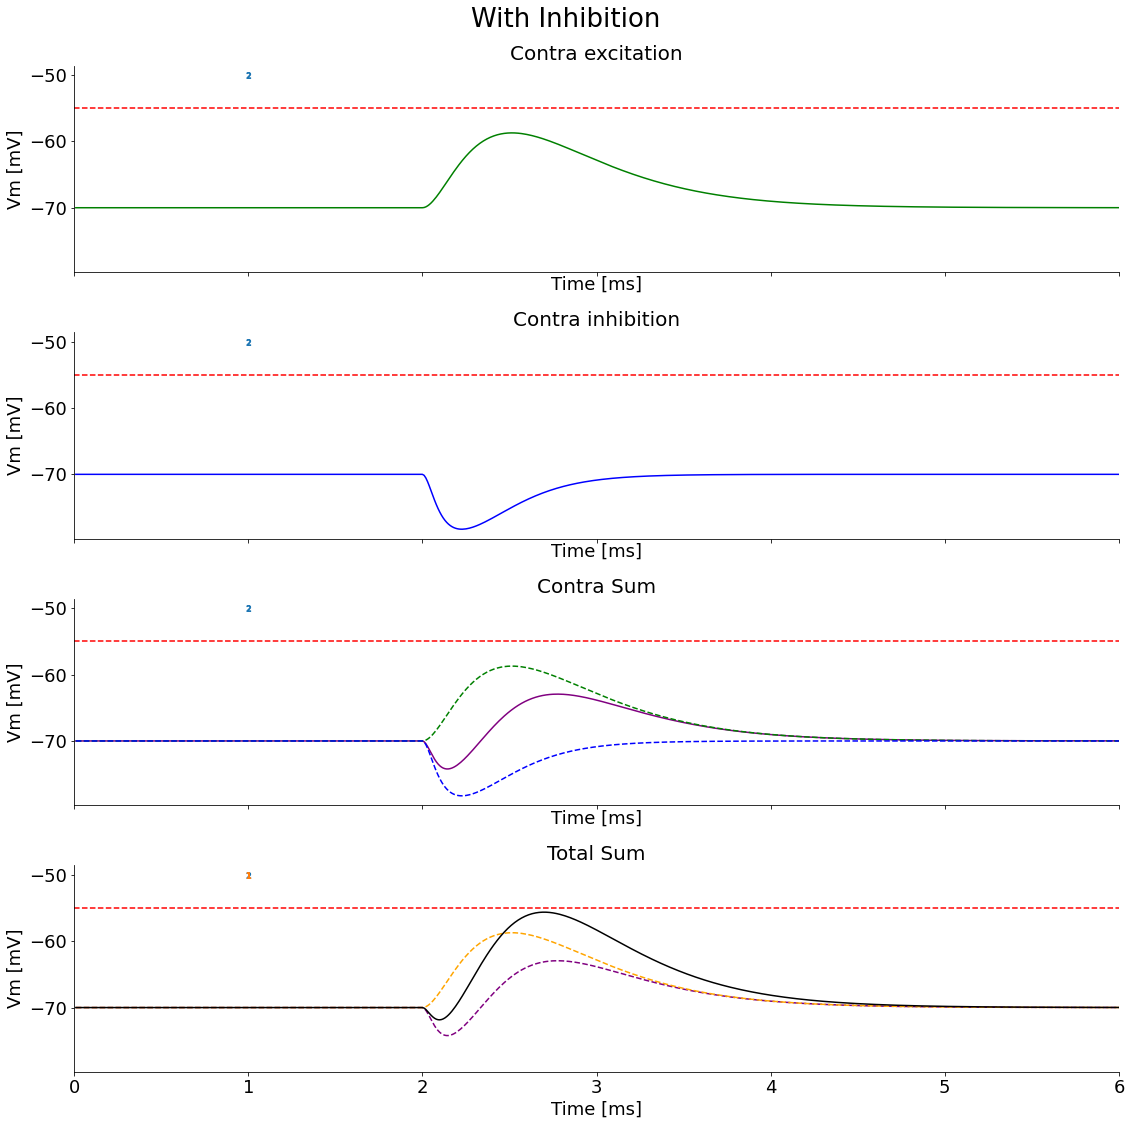

In [365]:
fig, ax = plt.subplots(4, figsize=(16,16), sharey = True, sharex = True)

for j in range(4):
    ax[j].set_xlim(0,6)
    ax[j].axhline(y = mso[j].get('V_th'), color = 'r', linestyle = '--')
    ax[j].spines['top'].set_visible(False)
    ax[j].spines['right'].set_visible(False)
    ax[j].plot(data['times'][np.where(data['senders'] == contra_e.get('global_id'))], (-50)*np.ones(len(data['times'][np.where(data['senders'] == contra_e.get('global_id'))])), marker = '${}$'.format(contra_e.get('global_id')), linestyle = 'None')
    ax[j].set_xlabel("Time [ms]")
    ax[j].set_ylabel("Vm [mV]")
    
fig.suptitle("With Inhibition")

ax[0].set_title('Contra excitation')
ax[0].plot(pot['times'][np.where(pot['senders'] == mso[1].get('global_id'))], pot['V_m'][np.where(pot['senders'] == mso[1].get('global_id'))], color = col[1])

ax[1].set_title('Contra inhibition')
ax[1].plot(pot['times'][np.where(pot['senders'] == mso[3].get('global_id'))], pot['V_m'][np.where(pot['senders'] == mso[3].get('global_id'))], color = col[3])

ax[2].set_title('Contra Sum')
ax[2].plot(pot['times'][np.where(pot['senders'] == mso[4].get('global_id'))], pot['V_m'][np.where(pot['senders'] == mso[4].get('global_id'))], color = col[4])
ax[2].plot(pot['times'][np.where(pot['senders'] == mso[1].get('global_id'))], pot['V_m'][np.where(pot['senders'] == mso[1].get('global_id'))], '--', color = col[1])
ax[2].plot(pot['times'][np.where(pot['senders'] == mso[3].get('global_id'))], pot['V_m'][np.where(pot['senders'] == mso[3].get('global_id'))], '--', color = col[3])

ax[3].set_title('Total Sum')
ax[3].plot(pot['times'][np.where(pot['senders'] == mso[4].get('global_id'))], pot['V_m'][np.where(pot['senders'] == mso[4].get('global_id'))], '--', color = col[4])
ax[3].plot(pot['times'][np.where(pot['senders'] == mso[0].get('global_id'))], pot['V_m'][np.where(pot['senders'] == mso[0].get('global_id'))], '--', color = col[0])
ax[3].plot(pot['times'][np.where(pot['senders'] == mso[5].get('global_id'))], pot['V_m'][np.where(pot['senders'] == mso[5].get('global_id'))], color = col[5])
#ax[3].plot(pot['times'][np.where(pot['senders'] == mso[2].get('global_id'))], pot['V_m'][np.where(pot['senders'] == mso[2].get('global_id'))], '--', color = col[2])
ax[3].plot(data['times'][np.where(data['senders'] == ipsi_e.get('global_id'))], (-50)*np.ones(len(data['times'][np.where(data['senders'] == ipsi_e.get('global_id'))])), marker = '${}$'.format(ipsi_e.get('global_id')), linestyle = 'None')



fig.tight_layout()